<h2>Train the model to predict classes for my main dataset using a neural network (ktrain)

In [1]:
# !pip install tensorflow
# !pip install ktrain
# # Credits: https://www.narcis.nl/dataset/RecordID/oai%3Aeasy.dans.knaw.nl%3Aeasy-dataset%3A79182

import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()
from sklearn.model_selection import train_test_split

import warnings, os, re
warnings.filterwarnings("ignore")

<h3>The training dataset</h3>
<p>It comes in 5 classes as follows:
<li>0: Culture
<li>1: Diverse
<li>2: Economy
<li>3: Politics
<li>4: Sport

In [ ]:
# Function to read csv inside zip file for pandas
def extract_df(url):
    # Necessary packages
    import re, requests, shutil, zipfile, os
    import pandas as pd
    # The url where we can fide the file
    url_df = url
    # The name of the zip file
    file_df = re.findall(r'([^\/]+$)', url)[0]
    if '.zip' not in file_df:
        files_dir = file_df+'.zip'
    else:
        files_dir = file_df
    if not os.path.exists(files_dir):
        os.mkdir(files_dir)
    # Command to donwload the file at the given url
    r = requests.get(url_df)
    # Then we open the file
    open(file_df, 'wb').write(r.content)
    # We extract the content of the .zip file
    with zipfile.ZipFile(file_df, 'r') as unzip:
        unzip.extractall(files_dir)
     # we finally read the csv and make some cleaning
    df = pd.read_csv(os.path.join(
        files_dir, [i for i in unzip.namelist() if i.endswith('.csv')][0]))
    # We remove files/dir
    shutil.rmtree(files_dir)
    os.remove(file_df)
    return df

In [50]:
categories = ['Culture','Diverse','Economy','Politics','Sport']
train_df = extract_df('https://data.mendeley.com/public-files/datasets/v524p5dhpj/files/72c2e306-9538-4c74-a28f-558fbe87c382/file_downloaded').rename(columns={'targe':'target'})
train_df

,text,target
0,بين أستوديوهات ورزازات وصحراء مرزوكة وآثار ولي...,0
1,قررت النجمة الأمريكية أوبرا وينفري ألا يقتصر ع...,0
2,أخبارنا المغربية الوزاني تصوير الشملالي ألهب ا...,0
3,اخبارنا المغربية قال ابراهيم الراشدي محامي سعد...,0
4,تزال صناعة الجلود في المغرب تتبع الطريقة التقل...,0
...,...,...
111723,اللاعب تأخر في العودة إلى التداريب والمدرب غاض...,4
111724,المشرف العام لحسنية أكادير قال إنه سيغادر الفر...,4
111725,نسب إليه نتائج الوداد وصحوة الرجاء وآخر صيحاته...,4
111726,ستحتضن الرباط في الفترة مابين يوليوز المقبل دو...,4


In [4]:
# Train test split
texts = train_df.text.tolist()
target = train_df.target.tolist()

x_train, x_test, y_train, y_test = train_test_split(texts, target, test_size=.2, random_state=23)

<h4>Transformer Tokenizer for training

In [5]:
# !pip install ktrain --user
import ktrain
from ktrain import text
from transformers import AutoTokenizer, AutoModel, AutoModelForMaskedLM
model_name = "asafaya/bert-base-arabic"
tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForMaskedLM.from_pretrained(model_name)

In [6]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

transformer = text.Transformer(model_name, maxlen=512, class_names=categories)

# transformer.get_model()

<h5>New dataframe, then preprocess and then get the model from the transformer

In [7]:
df_2 = pd.concat([train_df, pd.get_dummies(train_df.target)],axis=1)
df_2

,text,target,0,1,2,3,4
0,بين أستوديوهات ورزازات وصحراء مرزوكة وآثار ولي...,0,1,0,0,0,0
1,قررت النجمة الأمريكية أوبرا وينفري ألا يقتصر ع...,0,1,0,0,0,0
2,أخبارنا المغربية الوزاني تصوير الشملالي ألهب ا...,0,1,0,0,0,0
3,اخبارنا المغربية قال ابراهيم الراشدي محامي سعد...,0,1,0,0,0,0
4,تزال صناعة الجلود في المغرب تتبع الطريقة التقل...,0,1,0,0,0,0
...,...,...,...,...,...,...,...
111723,اللاعب تأخر في العودة إلى التداريب والمدرب غاض...,4,0,0,0,0,1
111724,المشرف العام لحسنية أكادير قال إنه سيغادر الفر...,4,0,0,0,0,1
111725,نسب إليه نتائج الوداد وصحوة الرجاء وآخر صيحاته...,4,0,0,0,0,1
111726,ستحتضن الرباط في الفترة مابين يوليوز المقبل دو...,4,0,0,0,0,1


<h5>Initiate the training and testing data, clear the GPU usage, then initiate the model

In [8]:
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_df(df_2, 'text', label_columns=[0,1,2,3,4], preprocess_mode='standard', val_pct=0.1, ngram_range=3)

[0, 1, 2, 3, 4]
       0  1  2  3  4
97777  0  0  0  0  1
34053  0  0  1  0  0
28753  0  1  0  0  0
73464  0  0  0  0  1
48180  0  0  0  1  0
[0, 1, 2, 3, 4]
        0  1  2  3  4
92405   0  0  0  0  1
50903   0  0  0  1  0
30133   0  1  0  0  0
74727   0  0  0  0  1
109525  0  0  0  0  1
language: ar
Word Counts: 404129
Nrows: 97910
97910 train sequences
train sequence lengths:
	mean : 229
	95percentile : 534
	99percentile : 944
Adding 3-gram features
max_features changed to 18354937 with addition of ngrams
Average train sequence length with ngrams: 683
train (w/ngrams) sequence lengths:
	mean : 683
	95percentile : 1599
	99percentile : 2829
x_train shape: (97910,400)
y_train shape: (97910, 5)
Is Multi-Label? False
10879 test sequences
test sequence lengths:
	mean : 229
	95percentile : 534
	99percentile : 924
Average test sequence length with ngrams: 535
test (w/ngrams) sequence lengths:
	mean : 535
	95percentile : 1250
	99percentile : 2103
x_test shape: (10879,400)
y_test shape: (1087

In [9]:
# Clear the GPU memory
from numba import cuda
device = cuda.get_current_device()
device.reset()

# The model using NBSVM (Naive Bayes SVM) for text classification 
model = text.text_classifier('nbsvm', (x_train, y_train) , preproc=preproc)
learner = ktrain.get_learner(model, 
                             train_data=(x_train, y_train), 
                             val_data=(x_test, y_test), 
                             batch_size=16)

Is Multi-Label? False
compiling word ID features...
maxlen is 400
building document-term matrix... this may take a few moments...
rows: 1-10000
rows: 10001-20000
rows: 20001-30000
rows: 30001-40000
rows: 40001-50000
rows: 50001-60000
rows: 60001-70000
rows: 70001-80000
rows: 80001-90000
rows: 90001-97910
computing log-count ratios...
done.


<h4>Decide the best learning rate

simulating training for different learning rates... this may take a few moments...
Epoch 1/1024
6120/6120 [==============================] - 21s 3ms/step - loss: 6.0822 - accuracy: 0.8351


done.
Visually inspect loss plot and select learning rate associated with falling loss


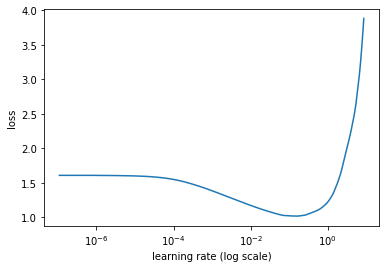

In [10]:
learner.lr_find(show_plot=True)

<h4>Train the Model

In [11]:
learner.autofit(5e-3, 1)



begin training using triangular learning rate policy with max lr of 0.005...
6120/6120 [==============================] - 63s 10ms/step - loss: 0.1664 - accuracy: 0.9672 - val_loss: 0.3068 - val_accuracy: 0.9534


In [20]:
learner

In [53]:
# Accuracy rate
learner.validate(class_names=categories)

              precision    recall  f1-score   support

     Culture       0.95      0.95      0.95      1413
     Diverse       0.96      0.95      0.96      1627
     Economy       0.89      0.90      0.89      1391
    Politics       0.91      0.91      0.91      2093
       Sport       0.99      0.99      0.99      4355

    accuracy                           0.95     10879
   macro avg       0.94      0.94      0.94     10879
weighted avg       0.95      0.95      0.95     10879



array([[1346,   10,   10,   38,    9],
       [  13, 1542,   32,   33,    7],
       [  18,   11, 1247,  109,    6],
       [  38,   32,  105, 1909,    9],
       [   7,    6,    8,    6, 4328]], dtype=int64)

<h4>Making Predictions on New Data


In [66]:
# Predictor
predictor = ktrain.get_predictor(learner.model, preproc=preproc)

# انتخاب = election ---- كرة القدم = football ---- جائزة أفضل ممثل = prize for the best actor
categories[predictor.predict('انتخاب')], categories[predictor.predict('كرة القدم')], categories[predictor.predict('جائزة أفضل ممثل')]


('Politics', 'Sport', 'Culture')

<h4>Save the model

In [70]:
predictor.save('3arabert_classifier')

<h4>Credits: </h4>
<li><a href="https://github.com/amaiya/ktrain">https://github.com/amaiya/ktrain</a>
<li><a href="htts://github.com/amaiya/ktrain/blob/master/examples/text">htts://github.com/amaiya/ktrain/blob/master/examples/text</a>